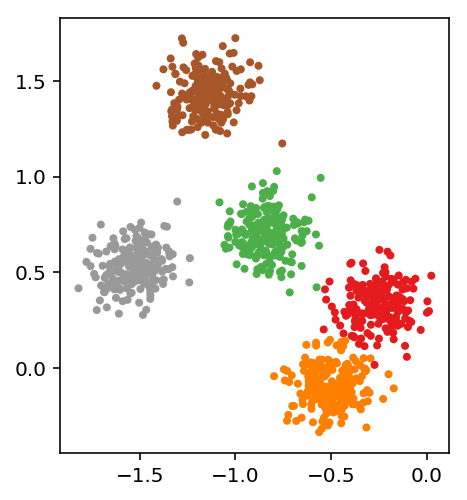

In [52]:
import variational_bayes as vb
import numpy as np
from matplotlib import pyplot as plt, rcParams
from tqdm import tqdm_notebook
import scipy.stats
%matplotlib inline
rcParams['figure.dpi'] = 144
rcParams['scatter.marker'] = '.'

np.random.seed(9)
num_samples = 1000
num_groups = 5
noise_precision = 100

z = np.random.choice(num_groups, num_samples)
group_mean = np.random.normal(0, 1, (num_groups, 2))
group_precision = scipy.stats.wishart.rvs(1000, [[1, -.5], [-.5, 1]], num_groups)
cholesky = np.linalg.cholesky(np.linalg.inv(group_precision))

x = group_mean[z] + np.einsum('iab,ia->ib', cholesky[z], np.random.normal(0, 1, (num_samples, 2)))
y = x + np.random.normal(0, 1, x.shape) / np.sqrt(noise_precision)

plt.scatter(*y.T, c=z, cmap='Set1')
plt.gca().set_aspect(1)

In [58]:
def mixture_model(num_groups):
    # Set up the factors
    q_mean = vb.MultiNormalDistribution(np.random.normal(0, 1e-3, (num_groups, 2)), 
                                        np.ones((num_groups, 1, 1)) * np.eye(2) * 1e-3)
    q_precision = vb.WishartDistribution(np.ones(num_groups) + 1e-5, np.ones((num_groups, 1, 1)) * np.eye(2) * 1e-5)
    q_z = vb.CategoricalDistribution(np.random.dirichlet(1000 * np.ones(num_groups), num_samples))
    q_x = vb.MultiNormalDistribution(y, np.ones((num_samples, 1, 1)) * np.eye(2) * 1e-3)
    
    # Evaluate the likelihood
    mixture_likelihood = vb.MixtureDistribution(
        q_z, vb.MultiNormalDistribution(q_mean, q_precision)
    ).likelihood(vb.ReshapedDistribution(q_x, (num_samples, 1)))
    y_likelihood = vb.MultiNormalDistribution(
        q_x, np.ones((num_samples, 1, 1)) * np.eye(2) * noise_precision
    ).likelihood(y)
    
    mean_prior = vb.MultiNormalDistribution(np.ones(2), 1e-4 * np.eye(2)).likelihood(q_mean)
    precision_prior = vb.WishartDistribution(2, 0.2 * np.eye(2)).likelihood(q_precision)
    z_prior = vb.CategoricalDistribution(np.ones(num_groups) / num_groups).likelihood(q_z)

    return vb.Model({'mean': q_mean, 'precision': q_precision, 'z': q_z, 'x': q_x}, 
                    [mixture_likelihood, z_prior, mean_prior, precision_prior, y_likelihood])

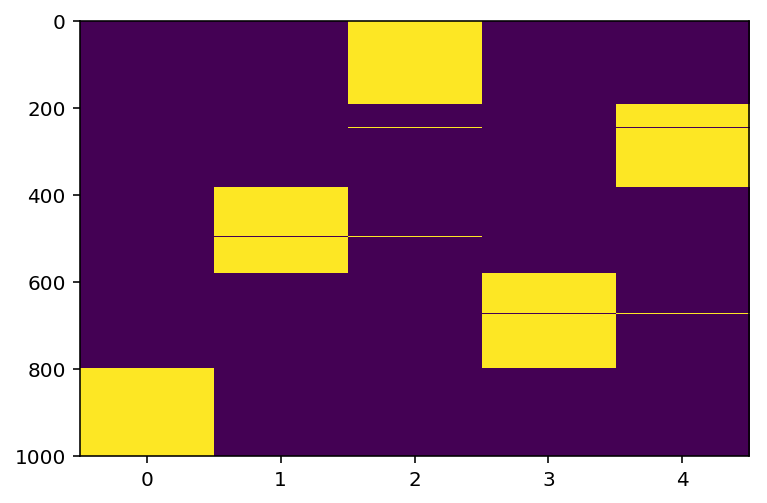

In [61]:
ensemble = vb.ModelEnsemble(mixture_model, [num_groups])
model = ensemble.update(100, None, tqdm_notebook, convergence_predicate=1e-5, num_processes=4)

plt.imshow(model['z'].mean[np.argsort(z)], aspect='auto')

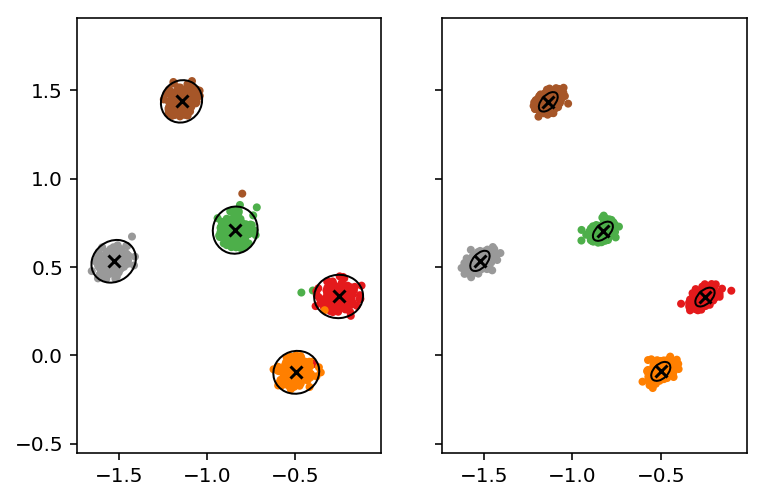

In [63]:
fig, (ax, ax2) = plt.subplots(1, 2, True, True)
ax.scatter(*model['x'].mean.T, c=z, cmap='Set1')
ax.scatter(*model['mean'].mean.T, marker='x', color='k')
for i in range(num_groups):
    ax.add_artist(vb.ellipse_from_cov(
        model['mean'].mean[i], 
        np.linalg.inv(model['precision'].mean[i]),
        facecolor='none', edgecolor='k'
    ))
    
ax2.scatter(*x.T, c=z, cmap='Set1')
ax2.scatter(*group_mean.T, marker='x', color='k')
for i in range(num_groups):
    ax2.add_artist(vb.ellipse_from_cov(
        group_mean[i], 
        np.linalg.inv(group_precision[i]),
        facecolor='none', edgecolor='k'
    ))
ax.set_aspect(1)

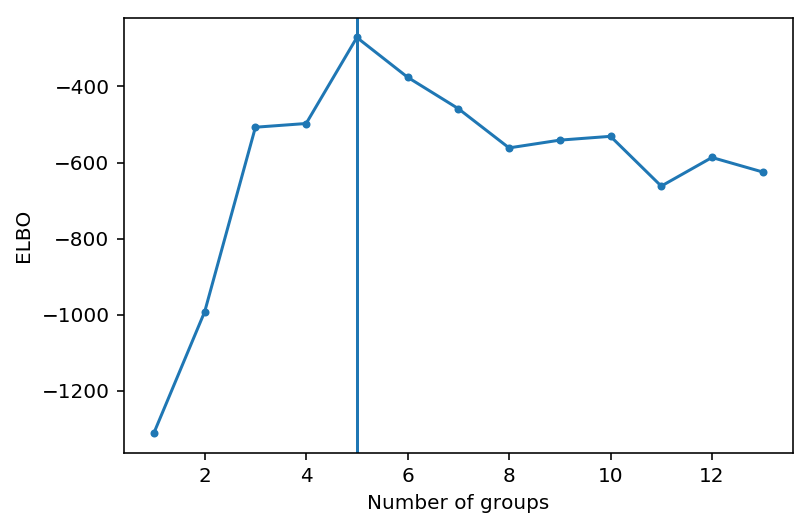

In [66]:
num = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13]
elbos = []

for n in tqdm_notebook(num):
    model = mixture_model(n)
    elbo, _ = model.update(200)
    elbos.append(elbo[-1])
    
plt.plot(num, elbos, marker='.')
plt.axvline(num_groups)
plt.ylabel('ELBO')
plt.xlabel('Number of groups')